# Assignment 3
## Sign Language Image Classification using Deep Learning

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (**excluding J and Z which require motion**). The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and **no cases for 9=J or 25=Z because of gesture motions**). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, $pixel_{1}$,$pixel_{2}$….$pixel_{784}$ which represent a single 28x28 pixel image with grayscale values between 0-255.

## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled data of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 100 training runs in total** (including all models and hyperparameter settings that you consider).  

The task requires you to create a Jupyter Notebook to perform 22 steps. These steps involve loading the dataset, fixing data problems, converting labels to one-hot encoding, plotting sample images, creating, training, and evaluating two sequential models with 20 Dense layers with 100 neurons each, checking for better accuracy using MC Dropout, retraining the first model with performance scheduling, evaluating both models, using transfer learning to create a new model using pre-trained weights, freezing the weights of the pre-trained layers, adding new Dense layers, training and evaluating the new model, predicting and converting sign language to text using the best model.

### IMPORTANT
* Train all the models locally on your own machine. No model training should occur on Gradescope (GS).
* After completing the training, upload the trained models' **h5 files** and their training histories along with your notebook to GS.
    * best_dnn_bn_model.keras
    * best_dnn_bn_perf_model.keras
    * best_dnn_selu_model.keras
    * best_mobilenet_model.keras
    * history1
    * history2
    * history1_perf
    * historymb
* To avoid any confusion and poor training on GS, please remember to comment out the training code in your notebook before uploading it to GS.


In [111]:
# import the necessary libraries (TensorFlow, sklearn NumPy, Pandas, and Matplotlib)


!pip install tensorflow
!pip install opencv-python

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Install opencv using "pip install opencv-python" in order to use cv2.
import cv2


**Step0** This test is for checking whether all the required files are submitted. Once you submit all the required files to the autograder, you will be able to pass this step.

**IMPORTANT:** Run this step to determine whether you have created all the required files correctly.

_Points:_ 1

In [54]:
# Don't change this cell code
required_files = ['best_dnn_bn_model.keras','best_dnn_bn_perf_model.keras','best_dnn_selu_model.keras','best_mobilenet_model.keras','history1','history2','history1_perf','historymb']
step0_files = True
for file in required_files:
    if os.path.exists(file) == False:
        step0_files = False
        print("One or more files are missing!")
        break

# The following code is used by the autograder. Do not modify it.   
step0_data = step0_files

### Data Preprocessing

**STEP1** Load the dataset (train and test) using `Pandas` from the CSV file.

_Points:_ 1

In [55]:
# Load the dataset using Pandas from the CSV file
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# The following code is used by the autograder. Do not modify it.
step1_sol = test_df.shape

**STEP2** Examine the data and fix any problems. It is important that you don't have gaps in the number of classes, therefore, check the classes which are not available and shift the labels in order to ensure 24 classes, starting from class 0. In addition, normalize the values of your images in a range of 0 and 1.

_Points:_ 1

In [56]:
# Separate labels and pixel values in training and testing sets

# Define the number of classes
num_classes = 24

# Separate labels and pixel values in training and testing sets
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values

test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values

# Shift labels to ensure 24 classes starting from class 0
train_labels -= min(train_labels)
test_labels -= min(test_labels)

# Ensure correct label encoding
train_labels = train_labels % num_classes
test_labels = test_labels % num_classes

# Print min and max shifted train labels for debugging
min_shifted_train_label = min(train_labels)
max_shifted_train_label = max(train_labels)
#print("Min shifted train label:", min_shifted_train_label)
#print("Max shifted train label:", max_shifted_train_label)

train_images = train_images / 255.0
test_images = test_images / 255.0

#train_labels = ...
#test_labels = ...
#train_images = ...
#test_images = ...

# The following code is used by the autograder. Do not modify it.
step2_sol = {
    "max_label_train": max(train_labels),
    "min_label_train": min(train_labels),
    "max_pixel_value_train": max(train_images.ravel()),
    "min_pixel_value_train": min(train_images.ravel()),
    "max_label_test": max(test_labels),
    "min_label_test": min(test_labels),
    "max_pixel_value_test": max(test_images.ravel()),
    "min_pixel_value_test": min(test_images.ravel())
}

In [57]:
print(step2_sol)

{'max_label_train': 23, 'min_label_train': 0, 'max_pixel_value_train': 1.0, 'min_pixel_value_train': 0.0, 'max_label_test': 23, 'min_label_test': 0, 'max_pixel_value_test': 1.0, 'min_pixel_value_test': 0.0}


**STEP3** Convert Labels to One-Hot Encoding both train and test.

_Points:_ 1

In [58]:
# Convert labels to one-hot encoding

from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_encoded = to_categorical(train_labels, num_classes=24)
test_labels_encoded = to_categorical(test_labels, num_classes=24)

# The following code is used by the autograder. Do not modify it.
step3_sol = {
    "train_labels_shape": train_labels_encoded.shape,
    "test_labels_shape": test_labels_encoded.shape,
    "sample_train_label": train_labels_encoded[0],
    "sample_test_label": test_labels_encoded[0]
}

**STEP4** Plot one sample image for each letter in the dataset given in the training set. To solve this step you should use the function `imshow` to diplay your images in a similar to the image below.

<center><img src="example_letters.jpg" width=400 height=300/></center>





_Points:_ 0

Label: 0, Indices: [   26    46    50 ... 27418 27422 27442]
Label: 1, Indices: [   29    30    95 ... 27411 27417 27435]
Label: 2, Indices: [    2     3    32 ... 27381 27386 27432]
Label: 3, Indices: [    0     8     9 ... 27336 27355 27362]
Label: 4, Indices: [   44    60    84    98   113   141   161   170   177   272   319   398
   437   451   488   516   534   537   539   601   613   628   631   632
   634   638   707   717   740   744   824   845   852   872   873   944
   975  1004  1027  1050  1092  1112  1116  1128  1182  1183  1185  1189
  1199  1244  1276  1346  1350  1352  1380  1391  1444  1460  1464  1468
  1543  1575  1638  1639  1649  1666  1668  1692  1735  1799  1805  1808
  1898  1963  1974  2024  2086  2153  2221  2256  2261  2271  2278  2281
  2294  2312  2317  2389  2419  2422  2436  2461  2463  2550  2561  2562
  2606  2641  2654  2663  2676  2678  2697  2717  2770  2772  2814  2819
  2845  2866  2867  2879  2896  2910  2938  2953  2972  2982  2998  3044
  3045 

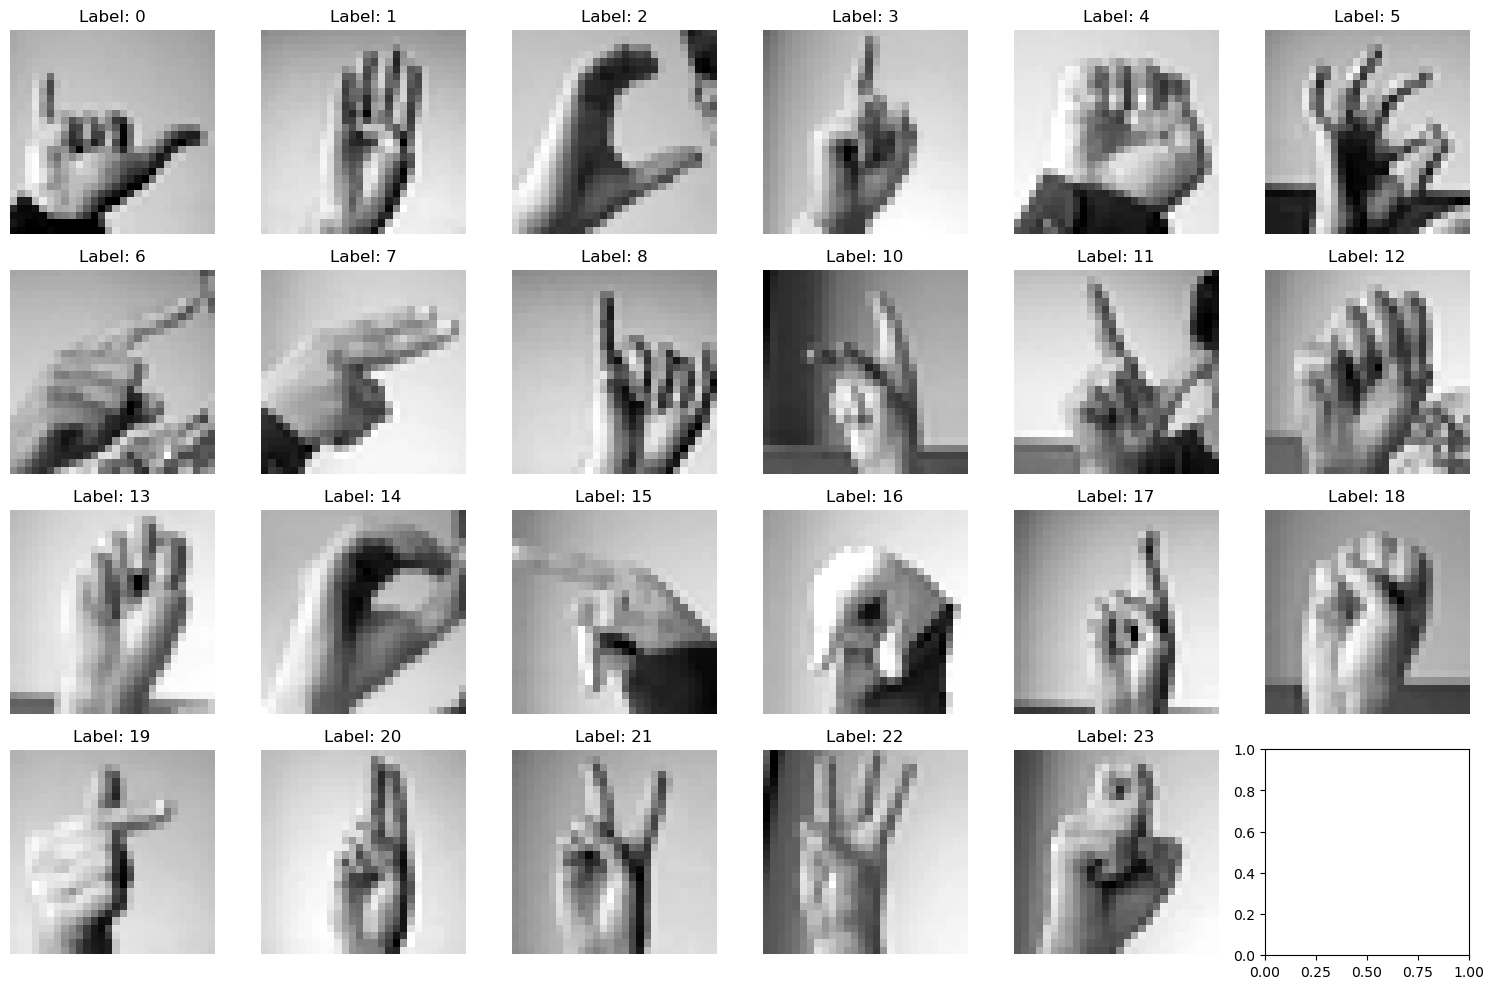

In [59]:
# Get one sample image for each label

import matplotlib.pyplot as plt

# Initialize a dictionary to store one sample image for each label
sample_images = {}

# Iterate through the training dataset
for label in range(24):  # Assuming there are 24 unique labels
    # Find indices of all occurrences of the current label
    indices = np.where(train_labels == label)[0]
    print(f"Label: {label}, Indices: {indices}")
    # If there are no occurrences of the current label, skip
    if len(indices) == 0:
        continue
    # Take the first occurrence of the label
    index = indices[0]
    # Extract the corresponding image
    sample_image = train_images[index]
    # Store the sample image for the current label
    sample_images[label] = sample_image

# Plot the sample images
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.flatten()
for i, (label, image) in enumerate(sample_images.items()):
    # Reshape the image to its original dimensions
    image = image.reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Plot the sample images

## Create Neural Network Architectures

In this part you should create two different models (model1 and model2) with different architectures.

**STEP5** 
Create one sequential model in `TensorFlow` with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output. 

* This model uses Batch Normalization after each Dense layer and uses He initialization for all of them. Apply Swish activation following each Batch Normalization.
* The input layer should be able to accept data of shape (784,), which corresponds to the flattened image data. The output layer should produce 24 outputs to correspond to each class.


_Points:_ 5

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import InputLayer

# Model 1: with Batch Normalization
model1 = tf.keras.Sequential()

# Add input layer
model1.add(InputLayer(input_shape=(784,)))

# Add Dense layers with Batch Normalization and Swish activation
for _ in range(20):
    model1.add(Dense(100, kernel_initializer='he_normal'))
    model1.add(BatchNormalization())
    model1.add(Activation(swish))

# Add output layer
model1.add(Dense(24, activation='softmax'))

# The following code is used by the autograder. Do not modify it.
step5_sol = {
    "total_layers": len(model1.layers),
    "output_activation": model1.layers[-1].activation.__name__,
    "first_layer_input_shape": model1.layers[0].input.shape,
    "last_layer_output_units": model1.layers[-1].units,
    "batch_norm_count": sum([1 for layer in model1.layers if isinstance(layer, BatchNormalization)]),
    "swish_activation_count": sum([1 for layer in model1.layers if hasattr(layer, 'activation') and layer.activation == swish]),
}

C:\Users\honey\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


**STEP6** 
Create a second sequential model in `TensorFlow` . This model should incorporate specific features to promote self-normalization and include regularization:

* Layers and Neurons: Construct the model with 20 Dense layers, each containing 100 neurons.
* Activation and Initialization:
  * Use SELU (Scaled Exponential Linear Unit) activation for each Dense layer to ensure self-normalization.
  * Initialize weights using the LeCun normal initializer in all Dense layers.
* Regularization:
  * Integrate Dropout with a rate of 0.1 after every second Dense layer starting from the second Dense layer to enhance model regularization without breaking self-normalization.
* Input and Output:
  * The input layer should accept flattened images with a dimension of 784 (28x28 images flattened).
  * The output layer should consist of 24 neurons with softmax activation to handle multi-class classification.

_Points:_ 5

In [61]:
# Model 2: with SELU and self-normalization

from tensorflow.keras.layers import Dense, Dropout

model2 = tf.keras.Sequential()

# Add input layer
model2.add(Dense(100, input_shape=(784,), activation='selu', kernel_initializer='lecun_normal'))

# Add Dense layers with SELU activation and LeCun normal initialization
selu_count = 1  # Start with 1 to include the input layer
dropout_count = 0
for i in range(2, 21):  # Loop through 20 Dense layers
    # Add Dense layer
    model2.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    selu_count += 1  # Count SELU layers
    # Add Dropout after every second Dense layer starting from the second Dense layer
    if i % 2 == 0 and dropout_count < 10:  # Applying dropout starting from index 2 (second Dense layer)
        model2.add(Dropout(0.1))
        dropout_count += 1

# Add output layer
model2.add(Dense(24, activation='softmax'))


# The following code is used by the autograder. Do not modify it.
step6_sol = {
    "total_layers": len(model2.layers),
    "dropout_count": sum([1 for layer in model2.layers if isinstance(layer, Dropout)]),
    "selu_count": sum([1 for layer in model2.layers if hasattr(layer, 'activation') and layer.activation.__name__ == 'selu']),
    "first_layer_config": model2.layers[0].get_config(),
    "output_layer_activation": model2.layers[-1].activation.__name__
}

C:\Users\honey\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
print(step6_sol)


{'total_layers': 31, 'dropout_count': 10, 'selu_count': 20, 'first_layer_config': {'name': 'dense_120', 'trainable': True, 'dtype': 'float32', 'units': 100, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'LecunNormal', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'output_layer_activation': 'softmax'}


## Compile the Models

**STEP7** 
Compile the both previous models using **Nadam** optimization. Also:

* Set the loss function to categorical cross-entropy. 
* Set the metric to accuracy.

_Points:_ 2

In [63]:
# Compile first model
model1.compile(optimizer='Nadam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Compile second model
model2.compile(optimizer='Nadam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
                        
# The following code is used by the autograder. Do not modify it.
step7_sol = {
    "model1_config": {
        "optimizer": str(model1.optimizer.__class__.__name__),
        "loss": model1.loss        
    },
    "model2_config": {
        "optimizer": str(model2.optimizer.__class__.__name__),
        "loss": model2.loss,        
    }
}

## Model Training

**STEP8** One of these models work preferably with data, which follow a normal distribution. Generate **train_images_scaled** and **test_images_scaled** using a `Sklearn` function that allow you to convert data to a normal distribution with mean 0 and variance equal 1. 

_Points:_ 2

In [64]:
from sklearn.preprocessing import StandardScaler

# initalise scaler
scaler = StandardScaler()

# Reshape the images for next step
train_images_reshaped = train_images.reshape(-1, 784)
test_images_reshaped = test_images.reshape(-1, 784)

train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.fit_transform(test_images)

# The following code is used by the autograder. Do not modify it.
step8_sol = (np.mean(train_images_scaled),np.mean(test_images_scaled),np.std(train_images_scaled),np.std(test_images_scaled))

**STEP9** Train the two models on the training dataset using early stopping. In order to save the results given by your training for your models, create checkpoints saving the best model in each case using the function `ModelCheckpoint`. Note that one of the models use the scaled data obtained in **STEP8**. Meanwhile, the other model does not. Figure out which is the proper input data for each model.

* Limit the number of epochs to 100. Set the batch size to or greater than 32.

**IMPORTANT:** Comment out the code to train/fit the two models. Keep the code given to save the models.

_Points:_ 3

In [65]:
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_labels, num_classes=24)
test_labels_one_hot = to_categorical(test_labels, num_classes=24)

# We go to set a seed to get the same results every run
np.random.seed(42)
tf.random.set_seed(42)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model 1: with Batch Normalization
model1 = tf.keras.Sequential()

# Add input layer
model1.add(InputLayer(input_shape=(784,)))

# Add Dense layers with Batch Normalization and Swish activation
for _ in range(20):
    model1.add(Dense(100, kernel_initializer='he_normal'))
    model1.add(BatchNormalization())
    model1.add(Activation('swish'))

# Configure the output layer
model1.add(Dense(24, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint callback
model1_checkpoint_cb = ModelCheckpoint("best_dnn_bn_model.keras", save_best_only=True)

# Train model 1
#history1 = model1.fit(train_images_scaled, train_labels_one_hot, epochs=100, batch_size=32,
#                      validation_data=(test_images_scaled, test_labels_one_hot),
#                      callbacks=[early_stopping, model1_checkpoint_cb])

 
# Model 2: with SELU activation and Batch Normalization
model2 = tf.keras.Sequential()

# Add input layer
model2.add(InputLayer(input_shape=(784,)))

# Add Dense layers with SELU activation and Batch Normalization
for _ in range(20):
    model2.add(Dense(100, kernel_initializer='lecun_normal'))
    model2.add(BatchNormalization())
    model2.add(Activation('selu'))

# Configure the output layer
model2.add(Dense(24, activation='softmax'))

# Compile model 2
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint callback
model2_checkpoint_cb = ModelCheckpoint("best_dnn_selu_model.keras", save_best_only=True)

#Train model 2
#history2 = model2.fit(train_images_scaled, train_labels_one_hot, epochs=100, batch_size=32,
#                      validation_data=(test_images_scaled, test_labels_one_hot),
#                      callbacks=[early_stopping, model2_checkpoint_cb])

# The following code will save your history - don't change it.
if 'history1' in globals():  
    with open('./history1', 'wb') as file_pi:
        pickle.dump(history1.history, file_pi)
if 'history2' in globals():  
    with open('./history2', 'wb') as file_pi:
        pickle.dump(history2.history, file_pi)
####################################

# The following code is used by the autograder. Do not modify it.
step9_sol = (model1_checkpoint_cb, model2_checkpoint_cb, early_stopping)

C:\Users\honey\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


**STEP10** After training, you must now evaluate the performance of the two previously saved models using the test datasets. Each model has different data requirements:
* Model 1 should be evaluated using the original test dataset.
* Model 2 should be evaluated using the scaled test dataset.
Load each model from their saved states, then perform the evaluation. To pass this step, both models must achieve a test accuracy greater than 50%.

_Points:_ 2

In [66]:
# Do not change the following 4 lines of code.
# define the file name for the saved model
model1_name = "best_dnn_bn_model.keras"
# load the model
model1 = keras.models.load_model(model1_name)
# define the file name for the saved model
model2_name = "best_dnn_selu_model.keras"
# load the model
model2 = keras.models.load_model(model2_name)

# Ensure the models are compiled
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the models on the test set
test_loss1, test_acc1 = model1.evaluate(test_images_scaled, test_labels_one_hot)
test_loss2, test_acc2 = model2.evaluate(test_images_scaled, test_labels_one_hot)

print(f"Model 1| Test accuracy: {test_acc1:.4f}, Test loss: {test_loss1:.4f}")
print(f"Model 2| Test accuracy: {test_acc2:.4f}, Test loss: {test_loss2:.4f}")

# The following code is used by the autograder. Do not modify it.
step10_sol = (test_loss1, test_acc1, test_loss2, test_acc2, model1, model2)

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7700 - loss: 0.9455
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7307 - loss: 1.2373
Model 1| Test accuracy: 0.7794, Test loss: 0.8946
Model 2| Test accuracy: 0.7355, Test loss: 1.1651


**STEP11** From the loaded history of the two trained models, plot a graph of **accuracy** vs **number of epochs** for both training and validation. 

_Points:_ 0

In [67]:
# Load history for model 1 (Do not modify this code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)
    
# Load history for model 2 (Do not modify this code)
history_name2 = "./history2"
with open(history_name2, "rb") as file_pi:
    loaded_history2 = pickle.load(file_pi)

# Plot the training and validation accuracies during training for both models

# The following code is used by the autograder. Do not modify it.
step11_sol = (loaded_history1, loaded_history2)

## MC Dropout

**STEP12** Check if model2 achieves better accuracy using MC Dropout (without retraining).

_Points:_ 3

In [68]:
#This function computes the MC (Monte Carlo) Dropout predictions for a given model and input data. 
# It returns the mean of multiple predictions obtained by running the model in training mode.
#Parameters
#   model: A trained model with a dropout layers.
#   X    : The input data for which the predictions are to be made.
#   n_samples: The number of Monte Carlo samples to generate..
#Returns
  # The function returns an array-like object containing the MC Dropout predictions for the given input data. 
  # The shape of the output should be the same as the model's output layer.

def mc_dropout_predict(model, X, n_samples=20):
    # Initialize an empty array to store predictions
    predictions = []

    # Generate predictions for each sample
    for _ in range(n_samples):
        predictions.append(model.predict(X))

    # Compute the mean of the predictions
    output_mc = np.mean(predictions, axis=0)

    return output_mc

# Call mc_dropout_predict to Compute the MC Dropout predictions for model 2
output_mc = mc_dropout_predict(model2, test_images_scaled)

# Compute the accuracy using MC Dropout
accuracy_mc = np.mean(np.argmax(output_mc, axis=1) == np.argmax(test_labels_one_hot, axis=1))

# Display result.
print(f"Model 2 with MC Dropout: Test accuracy: {accuracy_mc:.4f}")

# The following code is used by the autograder. Do not modify it.
step12_sol = (output_mc, accuracy_mc)

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Model 2 with MC Dropout: Test accuracy: 0.7355


## Learning Rate (LR) scheduling

**STEP13** Retrain model1 using performance scheduling and see if it improves training speed and model accuracy.

**IMPORTANT:** Define the model the same way model1 was defined and compile the model the same way as model1.

_Points:_ 2

In [69]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam


# Do not modify the following line of code.
history1_perf = None


train_labels_one_hot = to_categorical(train_labels, num_classes=24)
test_labels_one_hot = to_categorical(test_labels, num_classes=24)

np.random.seed(42)
tf.random.set_seed(42)

# Redefine Model 1 so we start again with random weights
model1_perfLRS = Sequential()

model1_perfLRS.add(InputLayer(input_shape=(784,)))

# Configure the output layer
model1_perfLRS.add(Dense(24, activation='softmax'))

# Compile the model with Nadam optimizer and categorical cross-entropy loss
model1_perfLRS.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Compile the model with Nadam optimizer and categorical cross-entropy loss

# Define the learning rate schedule
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Creating model checkpoint to save the best model. 
dnn_bn_perf_checkpoint_cb = ModelCheckpoint("best_dnn_bn_perf_model.keras", save_best_only=True)

#####Perform the training on your machine and then comment out the following section before uploading it to gradescope.
####################################  
# Make sure your best model is named as follows:
# Model1 with performance scheduling filename = best_dnn_bn_perf_model.keras


# Train the model using early stopping and exponential scheduling (Comment this out before submission)
#history1_perf = model1_perfLRS.fit(train_images_scaled, train_labels_one_hot, epochs=100, batch_size=32,
#                                   validation_data=(test_images_scaled, test_labels_one_hot),
#                                   callbacks=[early_stopping_cb, lr_scheduler, dnn_bn_perf_checkpoint_cb])

# The following code will save your history - don't change it - comment it out before uploading to GS
#if "history1_perf" in globals():
#    with open('./history1_perf', 'wb') as file_pi:
#        pickle.dump(history1_perf.history, file_pi)
####################################
# The following code is used by the autograder. Do not modify it.
step13_sol = (dnn_bn_perf_checkpoint_cb, lr_scheduler)

**STEP14** Using the loaded model obtained from the code given below, evaluate the performance of the model on the test set.

_Points:_ 1

In [98]:
# Do not change the following 2 lines of code.
# define the file name for the saved model
model_name = "best_dnn_bn_perf_model.keras"
# load the model
model1_perf = keras.models.load_model(model_name)

# Evaluate the model on the test set
test_loss1_perf, test_acc1_perf = model1_perf.evaluate(test_images_scaled, test_labels_one_hot)
print(f"Model 1 with performance scheduling: Test accuracy: {test_acc1_perf:.4f}")

# The following code is used by the autograder. Do not modify it.
step14_sol = (test_loss1_perf, test_acc1_perf)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6617 - loss: 1.1936
Model 1 with performance scheduling: Test accuracy: 0.6670


<!-- BEGIN QUESTION -->

**STEP15** From the history of the models loaded using the code given below, plot a graph of **accuracy** vs **number of epochs** for both training and validation.

_Points:_ 0

In [99]:
# load history for model 1 with learning rate scheduling (do not modify the following code)
history_name1_perf = "./history1_perf"
with open(history_name1_perf, "rb") as file_pi:
    loaded_history1_perf = pickle.load(file_pi)

# Load history for the original model1 (do not modify the following code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)

# Plot the training and validation accuracy for both models

<!-- END QUESTION -->

## Transfer learning

Use transfer learning by using a pre-trained **MobileNetV3Small** model on imagenet dataset, and fine-tuning it on the Sign Language MNIST dataset.

**STEP16** First of all, you to prepare your data for this model.
* Reshape your input data (train and test) to (28, 28, 3).
* Standardize your input. 

_Points:_ 2

In [212]:
# Reshape train data to (num_samples, 28, 28, 3)
train_images_mb = np.stack([train_images_scaled] * 3, axis=-1).reshape((-1, 28, 28, 3))

# Reshape test data to (num_samples, 28, 28, 3)
test_images_mb = np.stack([test_images_scaled] * 3, axis=-1).reshape((-1, 28, 28, 3))

# Normalise the data 
train_images_mb = train_images_mb.astype('float32')
test_images_mb = test_images_mb.astype('float32')
train_images_mb /= 255.0
test_images_mb /= 255.0

# The following code is used by the autograder. Do not modify it.
step16_sol = (train_images_mb,test_images_mb)

**Step17** Now, we need to define and set up the model. For this you need to follow the next steps:

* Load the pre-trained **MobileNetV3Small** model with weights from ImageNet.
* Modify the model to accept inputs of shape (56, 56, 3). 
* Freeze the weights of the pretrained layers.* 
* Add input layer that take an image of shape (28,28,3), then a layer `UpSampling2D` to upscale the input by a factor of 2 so they can go through the network.

Consider that maybe you need to adapt the default output.

_Points:_ 2

In [213]:
from tensorflow.keras.applications import MobileNetV3Small 
from tensorflow.keras.layers import Input, UpSampling2D, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load the pre-trained MobileNet model with weights from ImageNet
base_mb_model = MobileNetV3Small(input_shape=(56, 56, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
for layer in base_mb_model.layers:
    layer.trainable = False

# Create the new model
input_layer = Input(shape=(28, 28, 3))
x = UpSampling2D(size=(2, 2))(input_layer)
x = base_mb_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="swish")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(24, activation='softmax')(x)

final_mb_model = Model(inputs=input_layer, outputs=output_layer)

# The following code is used by the autograder. Do not modify it.
step17_sol = final_mb_model

**Step18** Once we define the model and do the specific modifications to adjust to our data, we compile it.

* Use a learning rate schedule that uses an exponential decay schedule.
* Compile and train the model.

_Points:_ 2

In [218]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an initial learning rate
initial_learning_rate = 0.02

# Create the proper learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 10000,
    decay_rate = 0.96,
    staircase = True 
)

final_mb_model = Model(inputs=input_layer, outputs=output_layer)


final_mb_model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# The following code is used by the autograder. Do not modify it.
step18_sol = (lr_schedule, final_mb_model)

**Step19** Train the mobilenet model. Include early stopping in your training procedure.

_Points:_ 2

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

# Do not modify the following line of code.
history_mb = None

# Define model checkpoint callback (Do not modify this code).
best_model_checkpoint = ModelCheckpoint("best_mobilenet_model.keras", save_best_only=True)

# Set up early stopping
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the training on your machine and then comment out the following section before uploading it to gradescope. 
#################################### 
# Train the model (comment this section out)
history_mb = final_mb_model.fit(
    train_images_mb, train_labels_one_hot,
    epochs=50,
    batch_size=128,
    validation_data=(test_images_mb, test_labels_one_hot),
    callbacks=[best_model_checkpoint, early_stopping_cb]
)

# Save the training history
if "history_mb" in globals():
    with open('./historymb', 'wb') as file_pi:
        pickle.dump(history_mb.history, file_pi)    
####################################

# The following code is used by the autograder. Do not modify it.
step19_sol = (best_model_checkpoint, early_stopping_cb)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 74s 195ms/step - accuracy: 0.5111 - loss: 1.4875 - val_accuracy: 0.5516 - val_loss: 1.4434
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.5050 - loss: 1.5107 - val_accuracy: 0.5703 - val_loss: 1.4336
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.5015 - loss: 1.5082 - val_accuracy: 0.5506 - val_loss: 1.4225
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - accuracy: 0.5149 - loss: 1.4676 - val_accuracy: 0.5680 - val_loss: 1.3824
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - accuracy: 0.5172 - loss: 1.4784 - val_accuracy: 0.5499 - val_loss: 1.4277
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.5299 - loss: 1.4374 - val_accuracy: 0.5710 - val_loss: 1.3490
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.5205 - loss: 1.4490 - val_accuracy: 0.5768 - val_loss: 1.4424
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.5256 - loss: 1

In [ ]:
print(step

**Step20** For the trained model loaded using the code given below, evaluate its performance on the test set.

_Points:_ 1

In [207]:
# Do not modify the following two lines of code.
# define the file name for the saved model
model_name = "best_mobilenet_model.keras"
print("Original test images shape:", test_images.shape)

# Assuming test_labels_one_hot is already defined and loaded
test_labels = np.argmax(test_labels_one_hot, axis=1)

# Make the prediction using MobileNet model. Use the function predict.
prediction_test = np.argmax(final_mb_model.predict(test_images_mb), axis=1)

# Initialize dictionaries to count correct predictions and total samples per letter
correct_counts = {i: 0 for i in range(24)}
total_counts = {i: 0 for i in range(24)}

# Count correct predictions and total samples for each letter
for true_label, predicted_label in zip(test_labels, prediction_test):
    total_counts[true_label] += 1
    if true_label == predicted_label:
        correct_counts[true_label] += 1

# Calculate proportions of correct predictions for each letter
proportions = {i: correct_counts[i] / total_counts[i] if total_counts[i] > 0 else 0 for i in range(24)}

# Find the most difficult and easiest letters to predict
complex_letter_index = min(proportions, key=proportions.get)
easiest_letter_index = max(proportions, key=proportions.get)

# Map indices to letters
letters = [chr(i + ord('a')) for i in range(24)]

# Handle the letters j and z that are skipped in the dataset
letters.insert(9, 'j')
letters.insert(25, 'z')

# Identify the complex and easiest letters
complex_letter = letters[complex_letter_index]
easiest_letter = letters[easiest_letter_index]

# Print the results
print(f"Most complex letter to predict: {complex_letter}")
print(f"Easiest letter to predict: {easiest_letter}")

# The following code is used by the autograder. Do not modify it.
step20_sol = (test_loss1_mobilenet,test_acc1_mobilenet)

Original test images shape: (7172, 784)
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step
Most complex letter to predict: j
Easiest letter to predict: o


**Step21** So far, you have seen the overall performance of your models. However, it is possible that some classes may be more difficult to classify than others. To gain a clearer understanding of which letters are the most difficult or easiest to predict, you can use your MobileNet model and make predictions on your test data using the predict function. Based on this, you can check the proportion of correct matches for each letter over the total number of that specific letter in the test data (as the proportion of one letter may differ from that of others). Finally, return the result as a string indicating the most complex and easiest letter to predict based on our analysis (e.g., "a" in lowercase).

_Points:_ 2

In [ ]:
# Put here again the labels (not hot encoded)
test_labels = np.argmax(test_labels_one_hot, axis=1)

# Make the prediction using MobileNet model. Use the function predict.
prediction_test = np.argmax(final_mb_model.predict(test_images_mb), axis=1)

# Initialize dictionaries to count correct predictions and total samples per letter
correct_counts = {i: 0 for i in range(24)}
total_counts = {i: 0 for i in range(24)}

# Count correct predictions and total samples for each letter
for true_label, predicted_label in zip(test_labels, prediction_test):
    total_counts[true_label] += 1
    if true_label == predicted_label:
        correct_counts[true_label] += 1

# Calculate proportions of correct predictions for each letter
proportions = {i: correct_counts[i] / total_counts[i] for i in range(24)}

# Find the most difficult and easiest letters to predict
complex_letter_index = min(proportions, key=proportions.get)
easiest_letter_index = max(proportions, key=proportions.get)

# What is the most difficult letter to predict? (if you have many letters which are equally difficult to predict, pick up any of them. Only one and put in a string (e.g. "a"))
letters = [chr(i + ord('a')) for i in range(24)]
complex_letter = letters[complex_letter_index]

# What is the easist letter to predict? (if you have many letters which are equally easy to predict, pick up any of them. Only one and put in a string (e.g. "a"))
easiest_letter = letters[easiest_letter_index]

# Print the results
print(f"Most complex letter to predict: {complex_letter}")
print(f"Easiest letter to predict: {easiest_letter}")

# The following code is used by the autograder. Do not modify it.
step21_sol = (test_labels,prediction_test,complex_letter,easiest_letter)

## Using our final model

Finally, so far you got a powerful model capable to use it to predict in new data.

**Step22** 

**Predict on a new sample** Process the image `challenge1.jpg` and try to dechiper what is the letter in the image using your best model. Be aware that your model gives you numeric results, however you should convert this result in a proper output of letters (use lowercase letters).

_Points:_ 2

In [ ]:
# Load the image (do not modify this line of code)
img_challenge1 = cv2.imread('challenge1.jpg', cv2.IMREAD_GRAYSCALE)

# Plot the image (do not modify the following 2 lines of code)
plt.imshow(img_challenge1)
plt.show()

# Process the data
# resize 
img_resized = cv2.resize(img_challenge1, (28, 28))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
# Normalize the image
img_normalized = img_rgb / 255.0
# (1, 28, 28, 3)
img_expanded = np.expand_dims(img_normalized, axis=0)

# Load the best model
model_name = "best_mobilenet_model.keras"
final_mb_model = load_model(model_name)


# Predict in this data using your best model
prediction_challenge1 = final_mb_model.predict(img_expanded)
predicted_label = np.argmax(prediction_challenge1, axis=1)[0]

# Map the numeric prediction to the corresponding letter
letters = [chr(i + ord('a')) for i in range(24)]

# Decoding result. This should be the string representation of the output generated by your model.
result_challenge1 = letters[predicted_label]

# The following code is used by the autograder. Do not modify it.
step22_sol = (result_challenge1)